In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from glob import glob
import pandas as pd
from copy import deepcopy
from hydra import initialize, compose
import itertools
from matplotlib.ticker import MaxNLocator

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):  # ../../
    config = compose(config_name='config.yaml')  # , overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.utils import util

In [2]:
# combine CSVs from each run into one CSV
data_dir = config.machine.dir_00
total_csv = os.path.join(data_dir, 'total_pop.csv')
detectable_csv = os.path.join(data_dir, 'detectable_pop.csv')
util.delete_if_exists(total_csv)
util.delete_if_exists(detectable_csv)
total_df = util.combine_all_csvs(data_dir, 'total', total_csv)
detectable_df = util.combine_all_csvs(data_dir, 'detectable', detectable_csv)

Wrote combined CSV to /data/scratch/btwedig/mejiro/pipeline/00/total_pop.csv
Wrote combined CSV to /data/scratch/btwedig/mejiro/pipeline/00/detectable_pop.csv


In [3]:
# total_df.columns

In [4]:
# hist = total_df.hist(grid=False, figsize=(20, 20))

In [5]:
# detectable_df.columns

In [6]:
# hist = detectable_df.hist(grid=False, figsize=(20, 20))

In [7]:
slacs4_path = os.path.join(repo_dir, 'paper', 'supplemental', 'Bolton2008_Table4.csv')
slacs4_df = pd.read_csv(slacs4_path)

slacs5_path = os.path.join(repo_dir, 'paper', 'supplemental', 'Bolton2008_Table5.csv')
slacs5_df = pd.read_csv(slacs5_path)

In [8]:
# slacs_df.columns

In [9]:
# hist = slacs_df.hist(grid=False, figsize=(20, 20))
# plt.savefig(os.path.join(figure_dir, 'slacs_hist.png'))

In [10]:
# from pprint import pprint
survey_params = util.hydra_to_dict(config.survey)
# pprint(survey_params)

source_cut_band = survey_params['source_cut_band']
deflector_cut_band = survey_params['deflector_cut_band']

select histograms to show

In [11]:
# detectable lenses
velocity_dispersions = detectable_df.loc[:,'velodisp']
masses = detectable_df.loc[:,'massstel'] * 1e12
source_redshifts = detectable_df.loc[:,'redssour']
lens_redshifts = detectable_df.loc[:,'redslens']
einstein_radii = detectable_df.loc[:,'angleins']
num_images = detectable_df.loc[:,'numbimag']
source_magnitudes = detectable_df.loc[:,f'magtsour{source_cut_band}']
lens_magnitudes = detectable_df.loc[:,f'magtlens{deflector_cut_band}']
# source_x = detectable_df.loc[:,'xpossour']
# source_y = detectable_df.loc[:,'ypossour']
# lens_x = detectable_df.loc[:,'xposlens']
# lens_y = detectable_df.loc[:,'yposlens']

# total lenses
total_velocity_dispersions = total_df.loc[:,'velodisp']
total_masses = total_df.loc[:,'massstel'] * 1e12
total_source_redshifts = total_df.loc[:,'redssour']
total_lens_redshifts = total_df.loc[:,'redslens']
total_einstein_radii = total_df.loc[:,'angleins']
total_num_images = total_df.loc[:,'numbimag']
total_source_magnitudes = total_df.loc[:,f'magtsour{source_cut_band}']
total_lens_magnitudes = total_df.loc[:,f'magtlens{deflector_cut_band}']
# total_source_x = total_df.loc[:,'xpossour']
# total_source_y = total_df.loc[:,'ypossour']
# total_lens_x = total_df.loc[:,'xposlens']
# total_lens_y = total_df.loc[:,'yposlens']

# SLACS
slacs_velocity_dispersions = slacs4_df.loc[:,'sigma']
slacs_source_redshifts = slacs4_df.loc[:,'zBG']
slacs_lens_redshifts = slacs4_df.loc[:,'zFG']
slacs_einstein_radii = slacs5_df.loc[:,'bSIE']

In [12]:
snr_files = glob(f'{config.machine.dir_00}/snr_list_*.npy')
snr_list = list(itertools.chain.from_iterable([np.load(f) for f in snr_files]))

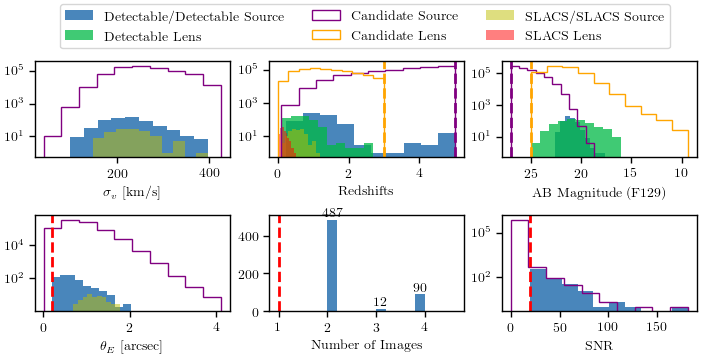

In [13]:
f, ax = plt.subplots(nrows=2, ncols=3, figsize=(7, 3), constrained_layout=True)
# bins = 10

ax[0][0].hist(velocity_dispersions, label='Detectable', alpha=0.75)
ax[0][0].hist(total_velocity_dispersions, label='Total', histtype='step', color='purple')  # weights=scale_total_det*np.ones_like(total_velocity_dispersions)
ax[0][0].hist(slacs_velocity_dispersions, label='SLACS', alpha=0.5, color='y')
ax[0][0].set_xlabel('$\sigma_v$ [km/s]')
ax[0][0].set_yscale('log')
# ax[0][0].set_ylim([0.5, 4e3])

# ax[0][1].hist(masses, label='Detectable', alpha=0.75)  # , bins=bins
# ax[0][1].hist(total_masses, label='Total', histtype='step', color='purple')
# ax[0][1].set_xlabel(r'$M_{\textrm{stellar}}$ [$M_\odot$]')
# ax[0][1].set_yscale('log')

ax[0][1].hist(source_redshifts, label='Detectable/Detectable Source', alpha=0.75)
ax[0][1].hist(lens_redshifts, label='Detectable Lens', alpha=0.75)
ax[0][1].hist(total_source_redshifts, label='Candidate Source', histtype='step', color='purple')
ax[0][1].hist(total_lens_redshifts, label='Candidate Lens', histtype='step', color='orange')
ax[0][1].hist(slacs_source_redshifts, label='SLACS/SLACS Source', alpha=0.5, color='y')
ax[0][1].hist(slacs_lens_redshifts, label='SLACS Lens', alpha=0.5, color='r')
ax[0][1].axvline(survey_params['source_z_max'], color='purple', linestyle='--')  # TODO get from config
ax[0][1].axvline(survey_params['deflector_z_max'], color='orange', linestyle='--')  # TODO get from config
ax[0][1].set_yscale('log')
# ax[0][1].set_xscale('log')
ax[0][1].set_xlabel('Redshifts')
# ax[0][1].set_xlim([0, 2])

# x1, x2, y1, y2 = 0, 2.25, 0.5, 1e3
# zoom_axes = ax[0][1].inset_axes(bounds=[0.475,0.3,0.425,0.45], xlim=(x1, x2), ylim=(y1, y2))
# zoom_axes.hist(source_redshifts, label='Detectable Source', alpha=0.75)
# zoom_axes.hist(lens_redshifts, label='Detectable Lens', alpha=0.75)
# zoom_axes.hist(slacs_source_redshifts, label='SLACS Source', alpha=0.5, color='y')
# zoom_axes.hist(slacs_lens_redshifts, label='SLACS Lens', alpha=0.5, color='r')
# zoom_axes.set_yscale('log')
# zoom_axes.tick_params(axis='y', which='both', left=False, labelleft=False)
# zoom_axes.set_xticks([0, 1.5])
# ax[0][1].indicate_inset_zoom(zoom_axes, edgecolor="black")

ax[0][2].hist(source_magnitudes, label='Source', alpha=0.75)
ax[0][2].hist(lens_magnitudes, label='Lens', alpha=0.75)
ax[0][2].hist(total_source_magnitudes, label='Total Source', histtype='step', color='purple')
ax[0][2].hist(total_lens_magnitudes, label='Total Lens', histtype='step', color='orange')
ax[0][2].axvline(survey_params['source_cut_band_max'], color='purple', linestyle='--')
ax[0][2].axvline(survey_params['deflector_cut_band_max'], color='orange', linestyle='--')
# ax[0][2].set_ylim([0, 250])
ax[0][2].set_yscale('log')
assert source_cut_band == deflector_cut_band, 'Source and deflector cut bands must be the same for the label on this plot to be true'
ax[0][2].set_xlabel(f'AB Magnitude ({source_cut_band})')
ax[0][2].invert_xaxis()

ax[1][0].hist(einstein_radii, label='Detectable', alpha=0.75, align='right')
ax[1][0].hist(total_einstein_radii, label='Total', histtype='step', color='purple')
ax[1][0].hist(slacs_einstein_radii, label='SLACS', alpha=0.5, color='y')
ax[1][0].axvline(0.2, color='r', linestyle='--')  # this should be at 0.4, but bins are aligned funky
# ax[1][0].axvline(5 / 2, color='r', linestyle='--')
ax[1][0].set_xlabel(r'$\theta_E$ [arcsec]')
ax[1][0].set_yscale('log')
# ax[1][0].set_xlim([0,2])

counts, edges, bars = ax[1][1].hist(num_images, label='Detectable', alpha=0.75)
ax[1][1].axvline(1, color='r', linestyle='--')
# counts_t, edges_t, bars_t = ax[1][0].hist(total_num_images, histtype='step')
ax[1][1].set_xlabel('Number of Images')
labels = [int(v) if v > 0 else '' for v in counts]
ax[1][1].bar_label(bars, labels=labels, label_type='edge')
# labels_t = [int(v) if v > 0 else '' for v in counts_t]
# ax[1][0].bar_label(bars_t, labels=labels_t, label_type='edge')
# ax[1][1].set_ylim([0., 1.5e3])  # make some space for the bar labels
ax[1][1].set_xlim([0.8, 4.8])  # make some space for the bar labels
ax[1][1].xaxis.set_major_locator(MaxNLocator(integer=True))
# ax[1][0].ticklabel_format(axis='y', style='plain', scilimits=(0,0))

# TODO it'd be nice if the histogram step and filled in line up better -- look into this
ax[1][2].hist([i for i in snr_list if i > survey_params['snr_threshold']], label='Detectable', alpha=0.75)
ax[1][2].hist(snr_list, label='Total', histtype='step', color='purple')
ax[1][2].axvline(x=survey_params['snr_threshold'], color='r', linestyle='--')
ax[1][2].set_xlabel('SNR')
ax[1][2].set_yscale('log')
# ax[1][0].set_xlim([0,2])

handles, labels = ax[0][1].get_legend_handles_labels()
f.legend(handles, labels, loc='upper center', ncols=3, bbox_to_anchor=(0.52, 1.2))

# plt.legend(loc='upper center', ncols=3)
plt.savefig(os.path.join(figure_dir, 'skypy_pop_hist.png'))
plt.show()